In [1]:
! pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
! install scipy

install: missing destination file operand after 'scipy'
Try 'install --help' for more information.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.stats import spearmanr, wilcoxon

# === Define image dataset ===
# e.g. filenames like "myelin_B0.0T.png", "myelin_B0.2T.png", "myelin_B0.5T.png"
image_files = sorted(glob.glob(""))

def extract_field_strength(filename):
    match = re.search(r"B(\d*\.?\d*)T", filename)
    return float(match.group(1)) if match else None

fields, S_values = [], []

for fname in image_files:
    B = extract_field_strength(fname)
    fields.append(B)

    # --- Load image and preprocess ---
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (5,5), 0)

    # --- Compute gradients ---
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    # --- Compute local orientation θ (radians) ---
    theta = 0.5 * np.arctan2(2 * gx * gy, gx**2 - gy**2)
    theta = np.nan_to_num(theta)

    # --- Mask out background ---
    mask = img > np.percentile(img, 60)
    theta_masked = theta[mask]

    # --- Compute order parameter S ---
    cos2 = np.cos(theta_masked)**2
    S = np.mean((3 * cos2 - 1) / 2)
    S_values.append(S)

    print(f"{fname}: S = {S:.4f}")

# === Plot S vs Magnetic Field ===
plt.figure(figsize=(7,5))
plt.plot(fields, S_values, 'o-', color='darkblue', label='Order parameter')
plt.xlabel("Magnetic Field Strength (T)")
plt.ylabel("Order Parameter (S)")
plt.title("Magnetic Reorientation of Myelin Figures")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Spearman correlation ===
rho, p_spearman = spearmanr(fields, S_values)
print(f"Spearman correlation (ρ) = {rho:.3f}, p = {p_spearman:.4f}")

# === Wilcoxon test ===
# Compare S-values before and after field application (e.g., first vs last)
if len(S_values) >= 2:
    try:
        stat, p_wilcoxon = wilcoxon([S_values[0]], [S_values[-1]])
        print(f"Wilcoxon test: statistic = {stat:.3f}, p = {p_wilcoxon:.4f}")
        if p_wilcoxon < 0.05:
            print("→ Significant reorientation detected (p < 0.05).")
        else:
            print("→ No significant difference detected.")
    except Exception as e:
        print(f"Wilcoxon test skipped: {e}")


In [3]:
! pip install glob

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [4]:
! pip install re

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


/content/SP1.5Na60_NC_25%GLU_6Glass slide_0170.JPG:  B = 0.0270 T   S = 0.3014
/content/SP1.5Na60_NC_25%GLU_6Glass slide_0171.JPG:  B = 0.0300 T   S = 0.3070
/content/SP1.5Na60_NC_25%GLU_6Glass slide_0172.JPG:  B = 0.0320 T   S = 0.3081
/content/SP1.5Na60_NC_25%GLU_6Glass slide_0173.JPG:  B = 0.0335 T   S = 0.3099


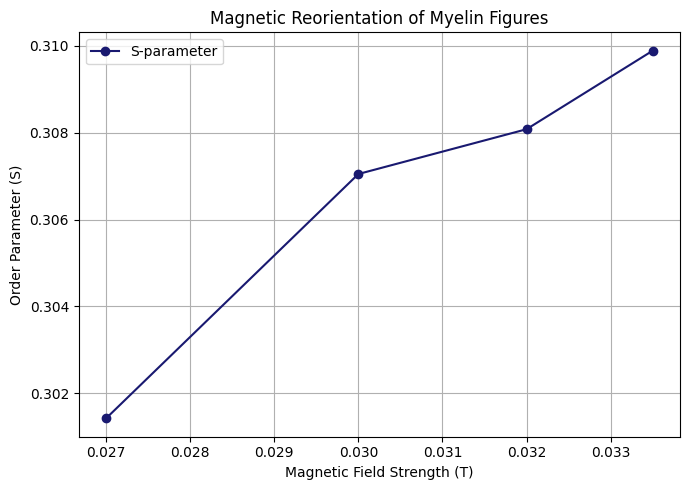

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Your image list (270 G → 346 G) ===
image_files = [
    '/content/SP1.5Na60_NC_25%GLU_6Glass slide_0170.JPG',
    '/content/SP1.5Na60_NC_25%GLU_6Glass slide_0171.JPG',
    '/content/SP1.5Na60_NC_25%GLU_6Glass slide_0172.JPG',
    '/content/SP1.5Na60_NC_25%GLU_6Glass slide_0173.JPG'

]

# === Define magnetic field values manually (in Gauss) ===
fields_gauss = [270, 300, 320, 335, 346]  # adjust these to match your actual measurement steps
fields_tesla = [g / 10000 for g in fields_gauss]  # Convert Gauss → Tesla

fields, S_values = [], []

for fname, B in zip(image_files, fields_tesla):
    # --- Load and smooth image ---
    img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not read {fname}")
        continue
    img = cv2.GaussianBlur(img, (5,5), 0)

    # --- Gradient and orientation ---
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
    theta = 0.5 * np.arctan2(2 * gx * gy, gx**2 - gy**2)
    theta = np.nan_to_num(theta)

    # --- Mask out background ---
    mask = img > np.percentile(img, 60)
    theta_masked = theta[mask]

    # --- Order parameter S ---
    cos2 = np.cos(theta_masked)**2
    S = np.mean((3 * cos2 - 1) / 2)
    fields.append(B)
    S_values.append(S)

    print(f"{fname}:  B = {B:.4f} T   S = {S:.4f}")

# === Plot S vs Magnetic Field ===
plt.figure(figsize=(7,5))
plt.plot(fields, S_values, 'o-', color='midnightblue', label='S-parameter')
plt.xlabel("Magnetic Field Strength (T)")
plt.ylabel("Order Parameter (S)")
plt.title("Magnetic Reorientation of Myelin Figures")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
rho, p_spearman = spearmanr(fields, S_values)
print(f"\nSpearman correlation ρ = {rho:.3f}, p = {p_spearman:.4f}")
if p_spearman < 0.05:
    print("→ Significant correlation between S and B (p < 0.05)")
else:
    print("→ No significant monotonic trend detected.")

# 2️⃣ Wilcoxon signed-rank test (first vs last field)
if len(S_values) >= 2:
    try:
        stat, p_wilcoxon = wilcoxon([S_values[0]], [S_values[-1]])
        print(f"Wilcoxon test: statistic = {stat:.3f}, p = {p_wilcoxon:.4f}")
        if p_wilcoxon < 0.05:
            print("→ Significant reorientation detected between first and last field (p < 0.05).")
        else:
            print("→ No significant difference detected.")
    except Exception as e:
        print(f"Wilcoxon test skipped: {e}")


Spearman correlation ρ = 1.000, p = 0.0000
→ Significant correlation between S and B (p < 0.05)
Wilcoxon test: statistic = 0.000, p = 1.0000
→ No significant difference detected.
